In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d #pre written interpolation function
from scipy.interpolate import griddata

In [2]:
def enum_other_states(n, min_s, max_s):
    """enumerate the state. for all palyers except player i
    (1,1,2) is equivalent to (1,2,1) from firm 1's pespective"""
    
    states_i = range(min_s,max_s)
    if n <=1:
        states = [[i] for i in states_i]
        return states
    else:
        states = []
        states_j = enum_other_states(n-1,min_s,max_s)
        for i in states_i:
            for j in states_j:
                if j[0] >= i:
                    state_ij = [i] + j 
                    states.append(state_ij)
        return states

In [3]:
class States:
    """class for dealing with the states
    these things are apparently really complex
    there are just a ton of them"""
    
    my_states = None #type nparray
    other_states = None #type np array 2d
    n = 0 #number of players
    max_states = 0
    min_states = 0
    

    def __init__(self, n, min_s,max_s):
        """initialize important class attributes"""
        self.n, self.min_states, self.max_states = n, min_s, max_s
      
    
    def gen_states(self):
        """compute all relevant states for firm i
        the trick is ommiting equivalent states
        this is taken care of in the helper function"""
        
        #avoid typing self a million times
        n, min_s, max_s  = self.n, self.min_states, self.max_states
        
        #setup other states
        other_states =  np.array(enum_other_states(n-1,min_s,max_s))
        num_others = other_states.shape[0]
        
        #initialize my states based on this
        my_states = np.arange(min_s,max_s)
        my_states = np.repeat(my_states,num_others )
        self.my_states = my_states
        
        #copy other states enough times
        other_states = other_states.reshape((1,num_others,n-1))
        other_states = np.tile(other_states,(max_s - min_s,1,1))  
        other_states = other_states.reshape(num_others*(max_s - min_s),n-1)
        self.other_states = other_states
    
    
    
    def make_states(self, my_states, other_states):
        """special initializer for states
        ensures they are not too big or too small"""
        
        assert np.array(other_states).shape[1] == (self.n -1)
        
        n, min_s, max_s  = self.n, self.min_states, self.max_states
        #make a copy to avoid side effects
        new_states = States(n,min_s,max_s)
        
        #ensure other my states are good
        my_states = np.array(my_states)
        my_states = np.minimum(max_s - 1, np.array(my_states))
        new_states.my_states = np.maximum(min_s, np.array(my_states))
        
        #ensure other states are good
        other_states = np.sort(other_states,axis=1)
        other_states = np.minimum(max_s - 1, np.array(other_states))
        new_states.other_states = np.maximum(min_s, np.array(other_states))
        
        return new_states
    
    
    def get_len(self):
        return len(self.other_states)
    
    
    def get_all(self):
        """return all the states"""
        reshaped_states = self.my_states.reshape((len(self.my_states),1))
        return np.concatenate( (reshaped_states, self.other_states), axis=1 )

In [4]:
def create_function(states, values):
    """returns a function and its max values
    the function uses the grid data to figure out return value"""
    f = lambda eval_states: griddata(states.get_all(), values, 
                                     eval_states.get_all(), method='linear')
       
    return f, np.amax(values)

In [5]:
def calc_bids(policy, states):
    """return the other players bids
    given the state by 'switching perspective'
    to other firm"""
    
    other_bids = []
    for i in range(1,states.n):
        other_states = states.get_all()
        my_other = other_states[:,i]
        other = np.delete(other_states, i, axis=1)
        other_states = states.make_states(my_other, other)
        other_bids.append( policy(other_states) )
    return np.array(other_bids).transpose()

In [6]:
def cost(states, shock,theta):
    """return the cost for firm 0"""
    return theta*states.my_states + shock


def tie_weighting(bids):
    """return weighting when there's a tie"""
    n_states, n_players = bids.shape
    low_bid =  np.min(bids,axis=1)
    low_bid = np.repeat(low_bid, n_players).reshape(n_states,n_players)
    
    win = (bids <= low_bid)
    n_winners = win.sum(axis=1)*1.
    n_winners = np.repeat(n_winners, n_players).reshape(n_states,n_players)
    return win/(1.*n_winners)


def profit(bids, states, contract, shock, theta):
    """return firm 0's profit"""
    my_bids = bids[:,0]
    profits = contract*tie_weighting(bids)[:,0]*(my_bids - cost(states,shock,theta))  
    return profits


def update_state(bids, states, contract):
    """update all firms states based on bids"""
    new_states = contract*tie_weighting(bids) + states.get_all()
    return states.make_states(new_states[:,0],np.delete(new_states,0,axis=1))

In [7]:
def operator(v_init, p_init, bids, states, theta, beta):
    """update the value and the policy function for player 0
    
    since we are looking for symmetric eq, there is really just 1
    policy and value to keep track of"""
    
    #initialize contract and state to 0
    contract = 1
    shock = 0
    
    #repeat bids/states per each bid
    my_bids = np.repeat(bids,states.get_len())
    bid_states = states.get_all()
    bid_states = np.tile(bid_states,(len(bids),1))
    bid_states = states.make_states(bid_states[:,0],np.delete(bid_states,0,axis=1))
    
    #other bids in each bid state and concat with my bids
    other_bids = calc_bids(p_init, bid_states)
    all_bids = my_bids.reshape(len(my_bids),1)
    all_bids = np.concatenate((all_bids,other_bids), axis=1)
    
    #calculate see how the states would update
    next_states = update_state(all_bids, bid_states, contract)
    
    #calculate the value of the next state
    value = profit(all_bids, bid_states, contract,  shock, theta)
    value = value + beta*v_init(next_states)
    
    #reshape v_new to find argmax
    value = value.reshape((len(bids),states.get_len()))
    
    #use argmax to find policy/value functions
    policy = np.argmax(value,axis=0)
    policy = bids[policy]
    policy, p_max = create_function(states, policy) 
    
    value = np.max(value,axis=0)
    value, v_max = create_function(states, value)
    
    return  value, v_max, policy, p_max

In [8]:
def  markov_perfect_eq(error, maxiter, value, policy, bids, states, theta, beta):
    """calculate the value function in a symmetric
        markov perfect equilibria"""
    
    #initialize loop variables
    policy_conv = True
    value_conv = True #don't worry about value function for now
    p0_max, v0_max = -1,-1 #ensure the loop goes once
    
    while  maxiter >= 0 and (policy_conv or value_conv) :
        
        #iterate loop variables for each player
        value, v_max, policy, p_max = operator(value, policy, bids, states, theta, beta)
            
        #update loop variables
        maxiter = maxiter -1
        policy_conv = np.abs(v_max - v0_max) > error
        value_conv = np.abs(p_max - p0_max ) > error
        v0_max, p0_max = v_max,p_max
    
    return  value, policy

In [9]:
def gen_cross(states, fixed):
    """gen cross section for purposes of graphing policy"""
    
    my_states = np.arange(states.min_states,states.max_states)
    fixed_states = np.tile(fixed, len(my_states))
    fixed_states = fixed_states.reshape(len(my_states),states.n-1)   
   
    return states.make_states(my_states,fixed_states)


def graph_functions(function, cross_sections, labels):
    """graph function on predetermined cross section"""
    for i in range(len(function)):
        #set up labels
        fig = plt.figure()
        plt.xlabel("Firm i's State")
        plt.ylabel("Firm i's %s Function"%labels[i])
        for cross in cross_sections:
            plt.plot( cross.my_states, function[i](cross), label=str(cross.other_states[0]) )
        plt.legend()

In [34]:
bids = np.arange(1,3)*4
n=3
states = States(n,1,9)
states.gen_states()
values = np.concatenate([np.ones(states.get_len()/2),2*np.ones(states.get_len()/2)])
policy, p_max = create_function(states, values)
value, policy = markov_perfect_eq(.0001, 200, policy, policy, bids, states, .7, .9)

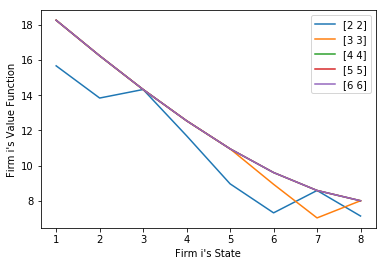

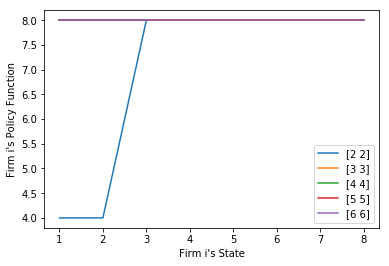

In [35]:
#make a cross section
cross_sections = []
for i in range(1,6):
    cross_sections.append(gen_cross(states, [i+1]*(states.n-1) ))

graph_functions( (value,policy),cross_sections,['Value','Policy'])